<a href="https://colab.research.google.com/github/codingBuddh/Detection-of-Diabetic-Retinopathy-using-CNN/blob/main/Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: >

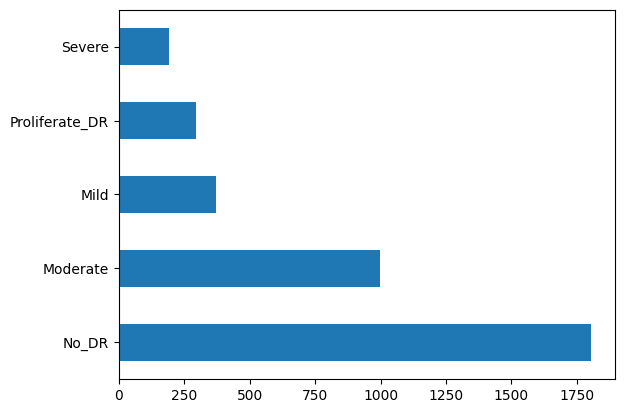

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

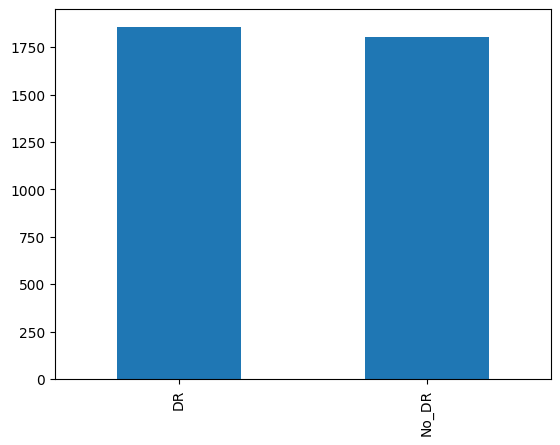

In [ ]:
df['binary_type'].value_counts().plot(kind='bar')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'/content/drive/MyDrive/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 27s 146ms/step - loss: 0.3592 - acc: 0.9114 - val_loss: 0.6781 - val_acc: 0.5073
Epoch 2/30
81/81 [==============================] - 10s 127ms/step - loss: 0.2032 - acc: 0.9325 - val_loss: 0.7257 - val_acc: 0.7036
Epoch 3/30
81/81 [==============================] - 8s 105ms/step - loss: 0.1554 - acc: 0.9477 - val_loss: 1.3549 - val_acc: 0.6200
Epoch 4/30
81/81 [==============================] - 10s 125ms/step - loss: 0.1226 - acc: 0.9571 - val_loss: 0.6995 - val_acc: 0.8618
Epoch 5/30
81/81 [==============================] - 10s 120ms/step - loss: 0.1113 - acc: 0.9575 - val_loss: 0.2627 - val_acc: 0.9182
Epoch 6/30
81/81 [==============================] - 9s 110ms/step - loss: 0.0983 - acc: 0.9617 - val_loss: 1.3383 - val_acc: 0.9255
Epoch 7/30
81/81 [==============================] - 9s 114ms/step - loss: 0.0680 - acc: 0.9559 - val_loss: 0.4927 - val_acc: 0.8982
Epoch 8/30
81/81 [==============================] - 8s 98ms/step - loss:

In [ ]:
model.save('64x3-CNN.model')

In [ ]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


<ipython-input-11-f081ff5ff9c3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 1s 75ms/step - loss: 0.7124 - acc: 0.9291
Accuracy:  0.9290909171104431


# ****Diabet Retinopathy Detection Section****

In [ ]:
model.save('/content/models/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')




1/1 [==============================] - 0s 144ms/step
DR


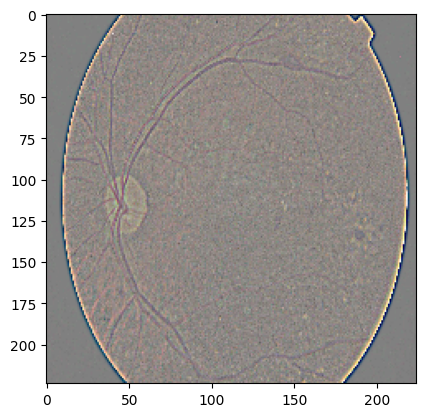

In [ ]:
predict_class('/content/test/DR/03c85870824c.png')